# Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания. Значение метрики RMSE на тестовой выборке должно быть не больше 48.


# 1. Анализ данных

In [1]:
!pip install catboost
!pip install lightgbm
!pip install xgboost
import catboost
from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [2]:
#импорт библиотек
import pandas as pd
import pathlib
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.metrics import mean_squared_error
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error as mse 
from numpy import mean
from numpy import absolute
from numpy import sqrt

In [3]:
#вызов датасета при помощи try для чтения на локальной версии и на тренажере яндекс. пратикум
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0], infer_datetime_format=True, cache_dates=True)
except:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0], infer_datetime_format=True, cache_dates=True)



In [4]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
max_num_order = data.copy()
max_num_order = max_num_order.loc[max_num_order['num_orders'] == 119]

print('Максимальное количество заказов', max_num_order)

Максимальное количество заказов                      num_orders
datetime                       
2018-08-13 02:20:00         119
2018-08-27 02:10:00         119


Максимальное количество заказов было 13 и 27 августа 2018 года.

In [6]:
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
data.tail(5)

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


Данные о заказах такси представлены с 01.03. 2018 года по 31.08.2018 года 

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [9]:
data.shape

(26496, 1)

In [10]:
print('Количество пропущенных значений в таблице:', data.isnull().sum().sum ())

Количество пропущенных значений в таблице: 0


In [11]:
print(data.index.is_monotonic)

True


Датафрейм состоит из 2 столбцов datatime(дата) и 'num_orders'(количество заказов). Пропущенных значений нет. Данные расположены в хронологическом порядке

# 1.2 Исследовательский анализ данных

C:\Users\User\AppData\Local\Temp\ipykernel_30468\804782514.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  day_sprint = day_sprint['2018-03-05']


Text(0, 0.5, 'Количество заказов')

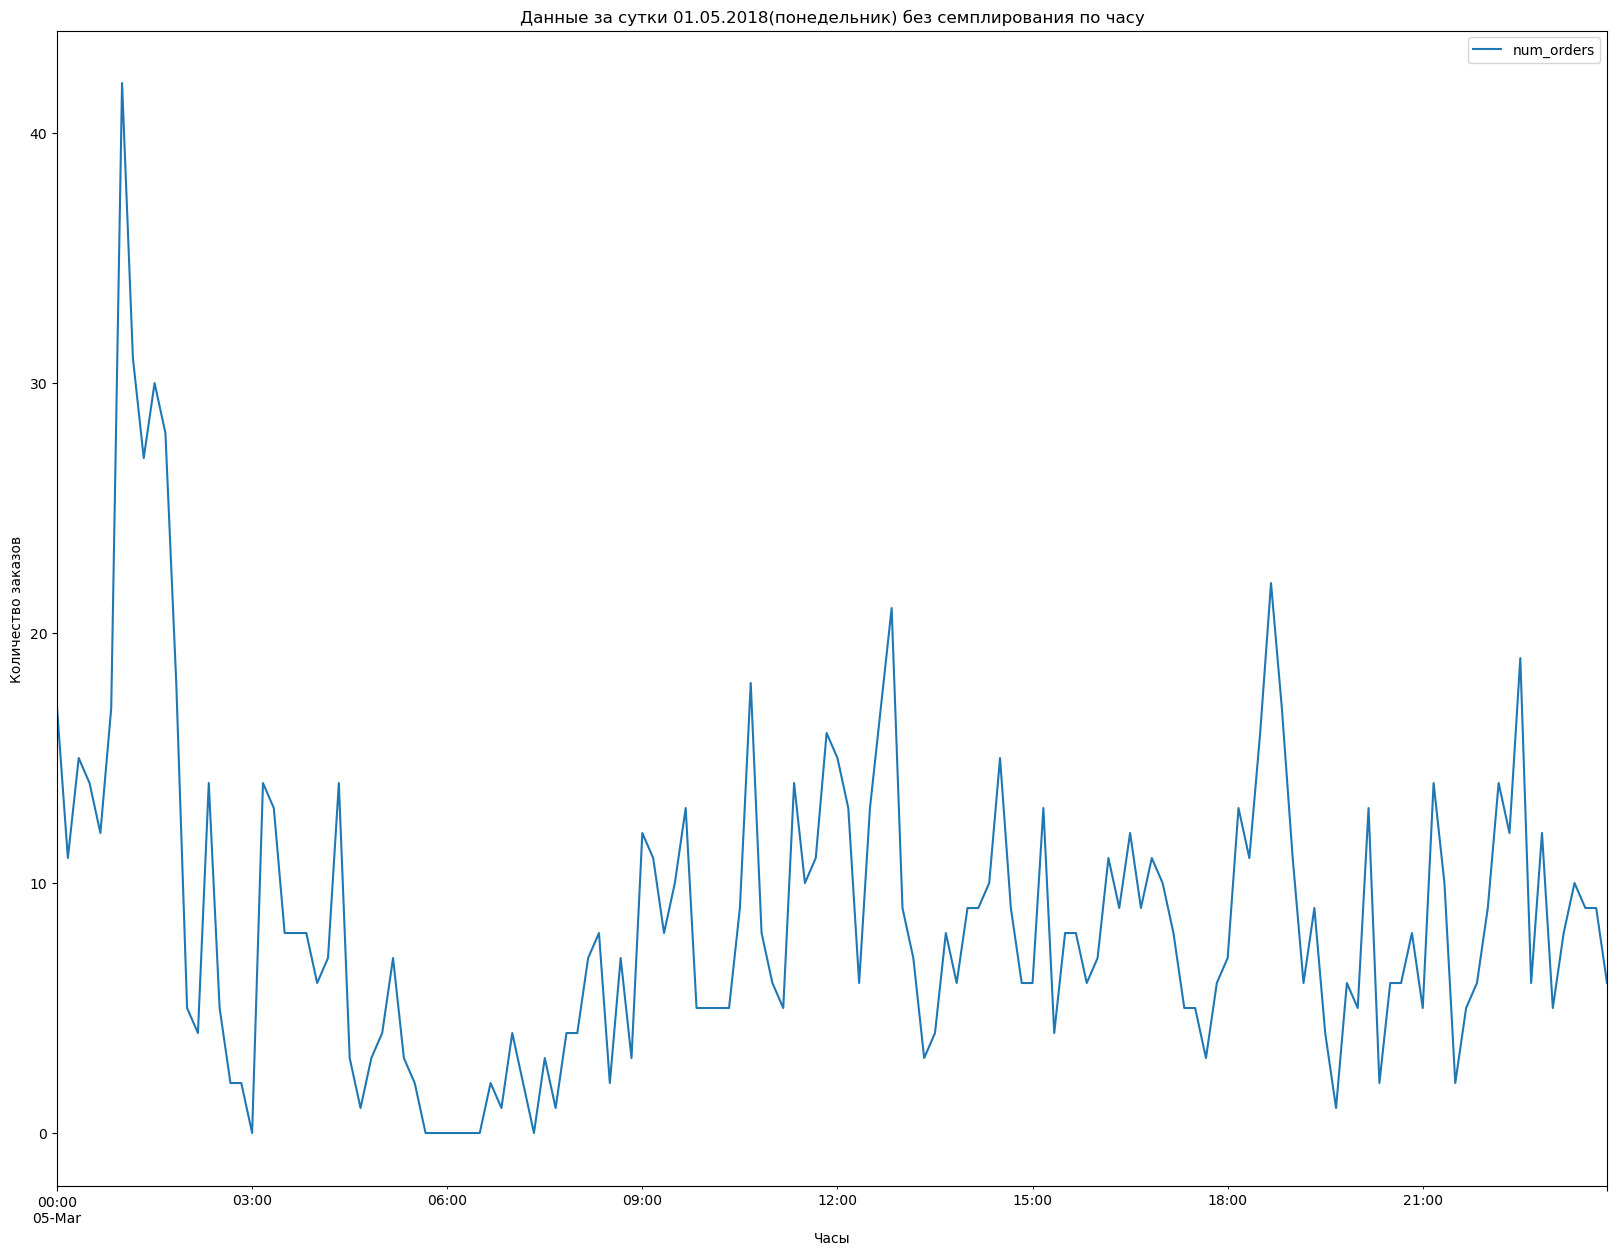

In [12]:
day_sprint = data.copy()
day_sprint = day_sprint['2018-03-05']
figsize = (20,15)
day_sprint.plot(figsize =figsize)
plt.title('Данные за сутки 01.05.2018(понедельник) без семплирования по часу')
plt.xlabel('Часы')
plt.ylabel('Количество заказов')

C:\Users\User\AppData\Local\Temp\ipykernel_30468\4106907089.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  day_summer = day_summer['2018-08-20']


Text(0, 0.5, 'Количество заказов')

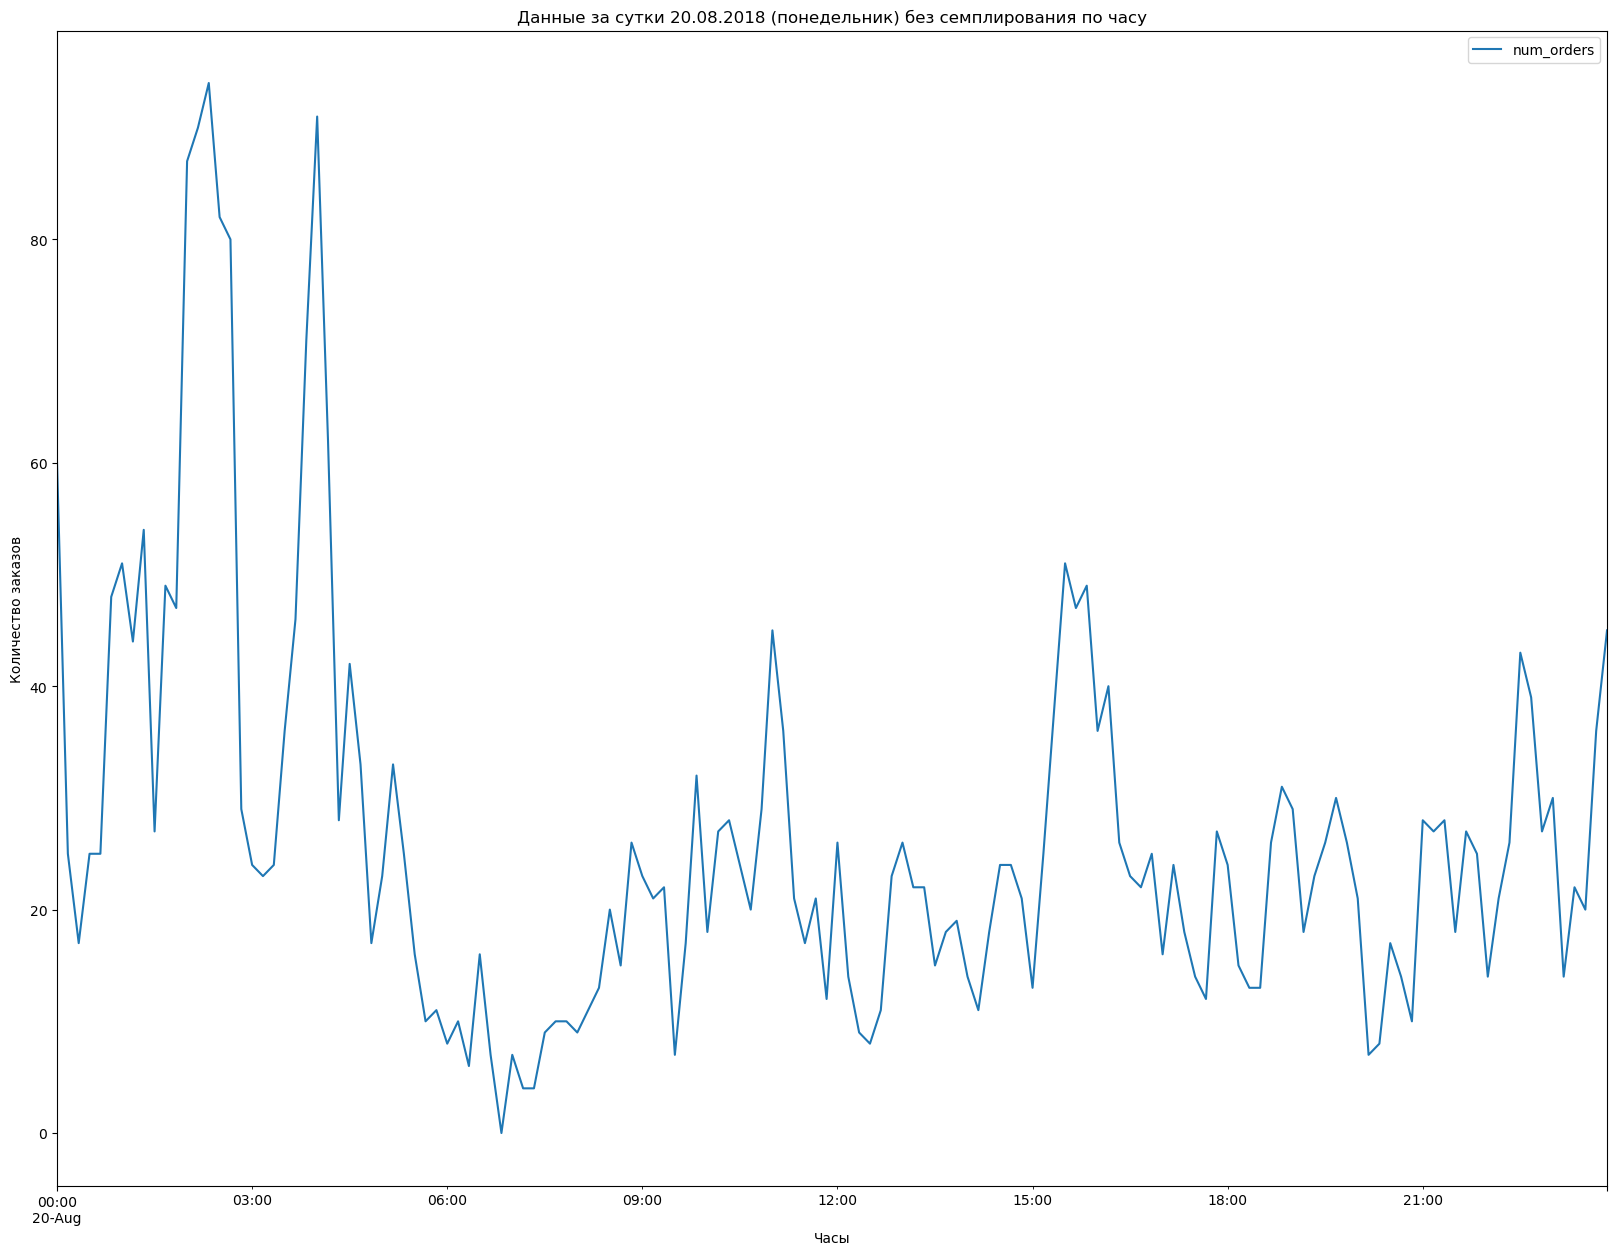

In [13]:
day_summer = data.copy()
day_summer = day_summer['2018-08-20']
figsize = (20,15)
day_summer.plot(figsize =figsize)
plt.title('Данные за сутки 20.08.2018 (понедельник) без семплирования по часу')
plt.xlabel('Часы')
plt.ylabel('Количество заказов')

Я рассмотрела и сравнила количество заказов 05.03.2018 и 20.08.2018. Оба дня являются понедельниками. Данные очень схожи. Исходя из графиков, выводы которые можно сделать. Наибольшее количество заказов поступает в периоды времени с 00:00 до 04:00 утра. С 04:00 до 09:00 утра самое низкое количество заказов такси. с 09:00 до 12:00 опять наблюдается рост количества заказов такси. С 15:00 до 21:00 опять начинается рост количества заказов. С 12 до 14 наблюдается снижение заказов. 

<AxesSubplot:xlabel='datetime'>

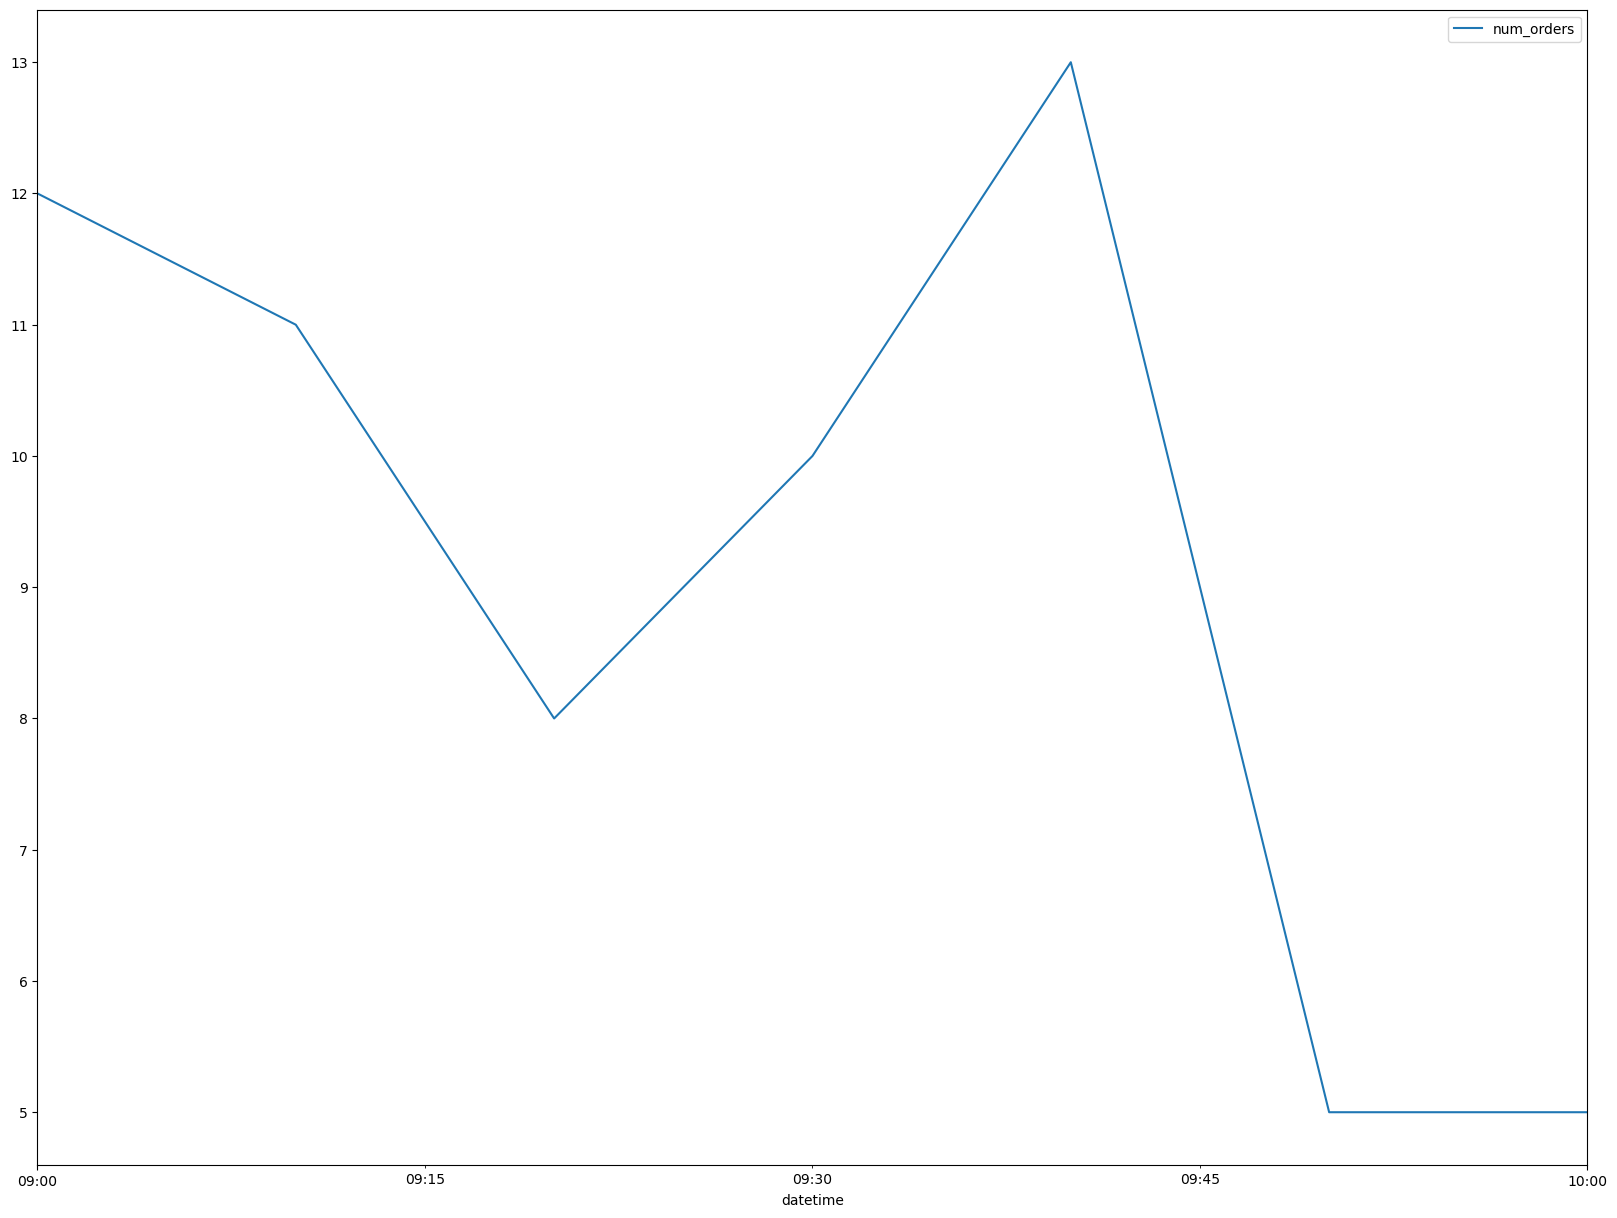

In [14]:
#распределение заказов течении одного часаhours = data.copy()
hour = data.copy()
hour = hour['2018-03-05 09:00:00 	':'2018-03-05 10:00:00 	']
figsize = (20,15)
hour.plot(figsize =figsize)

Наибольшее количество заказов за час в утреннее время 01.03.2018 г. в 09:40:00. В 09.30 пик заказов с утра. C 09:00:00 до 09:15:00 наименьшее количество заказов.


Text(0, 0.5, 'Количество заказов')

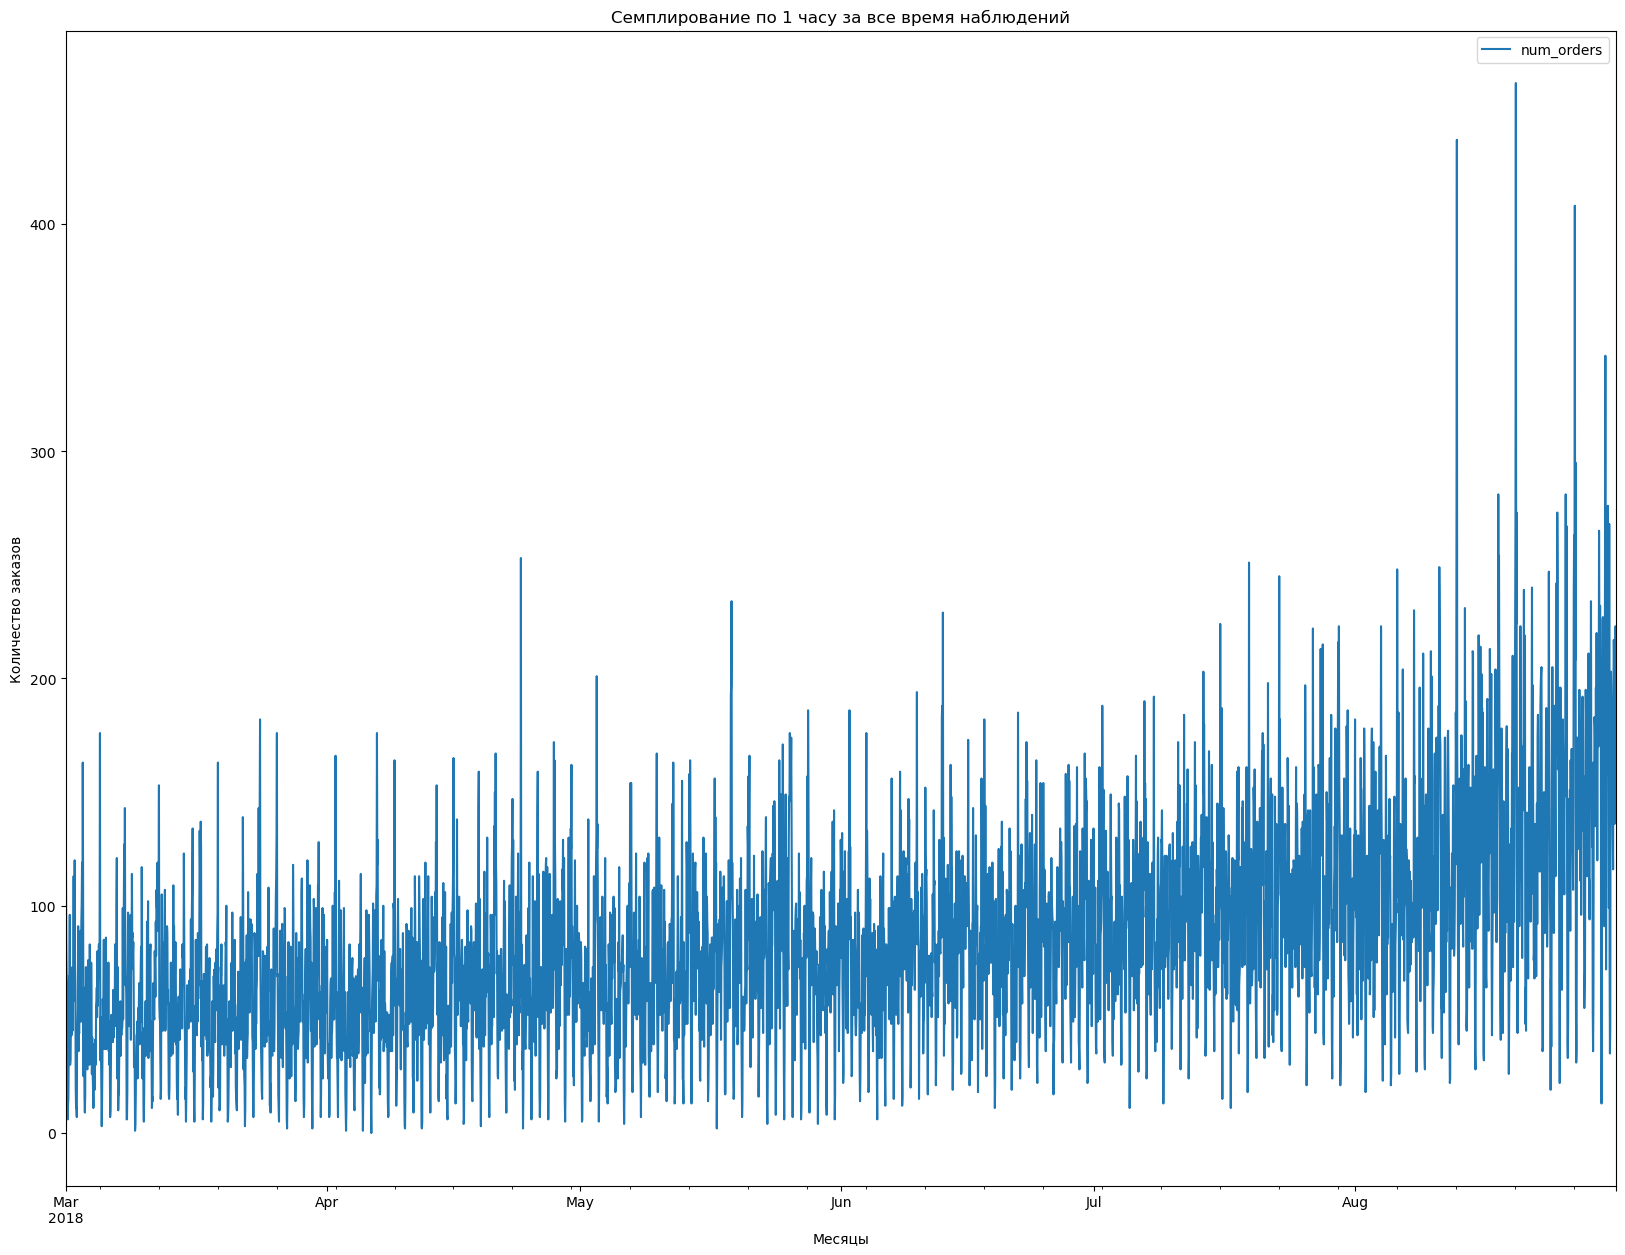

In [15]:
data = data.resample("1H").sum()
figsize = (20,15)
data.plot(figsize=figsize)
plt.title('Семплирование по 1 часу за все время наблюдений')
plt.xlabel('Месяцы')
plt.ylabel('Количество заказов')

Для анализа тренда и сезонности данных о количества заказов в такси я предлагаю для исследования использовать два сезона: весна и лето.Также рассмотреть распределение на неделе

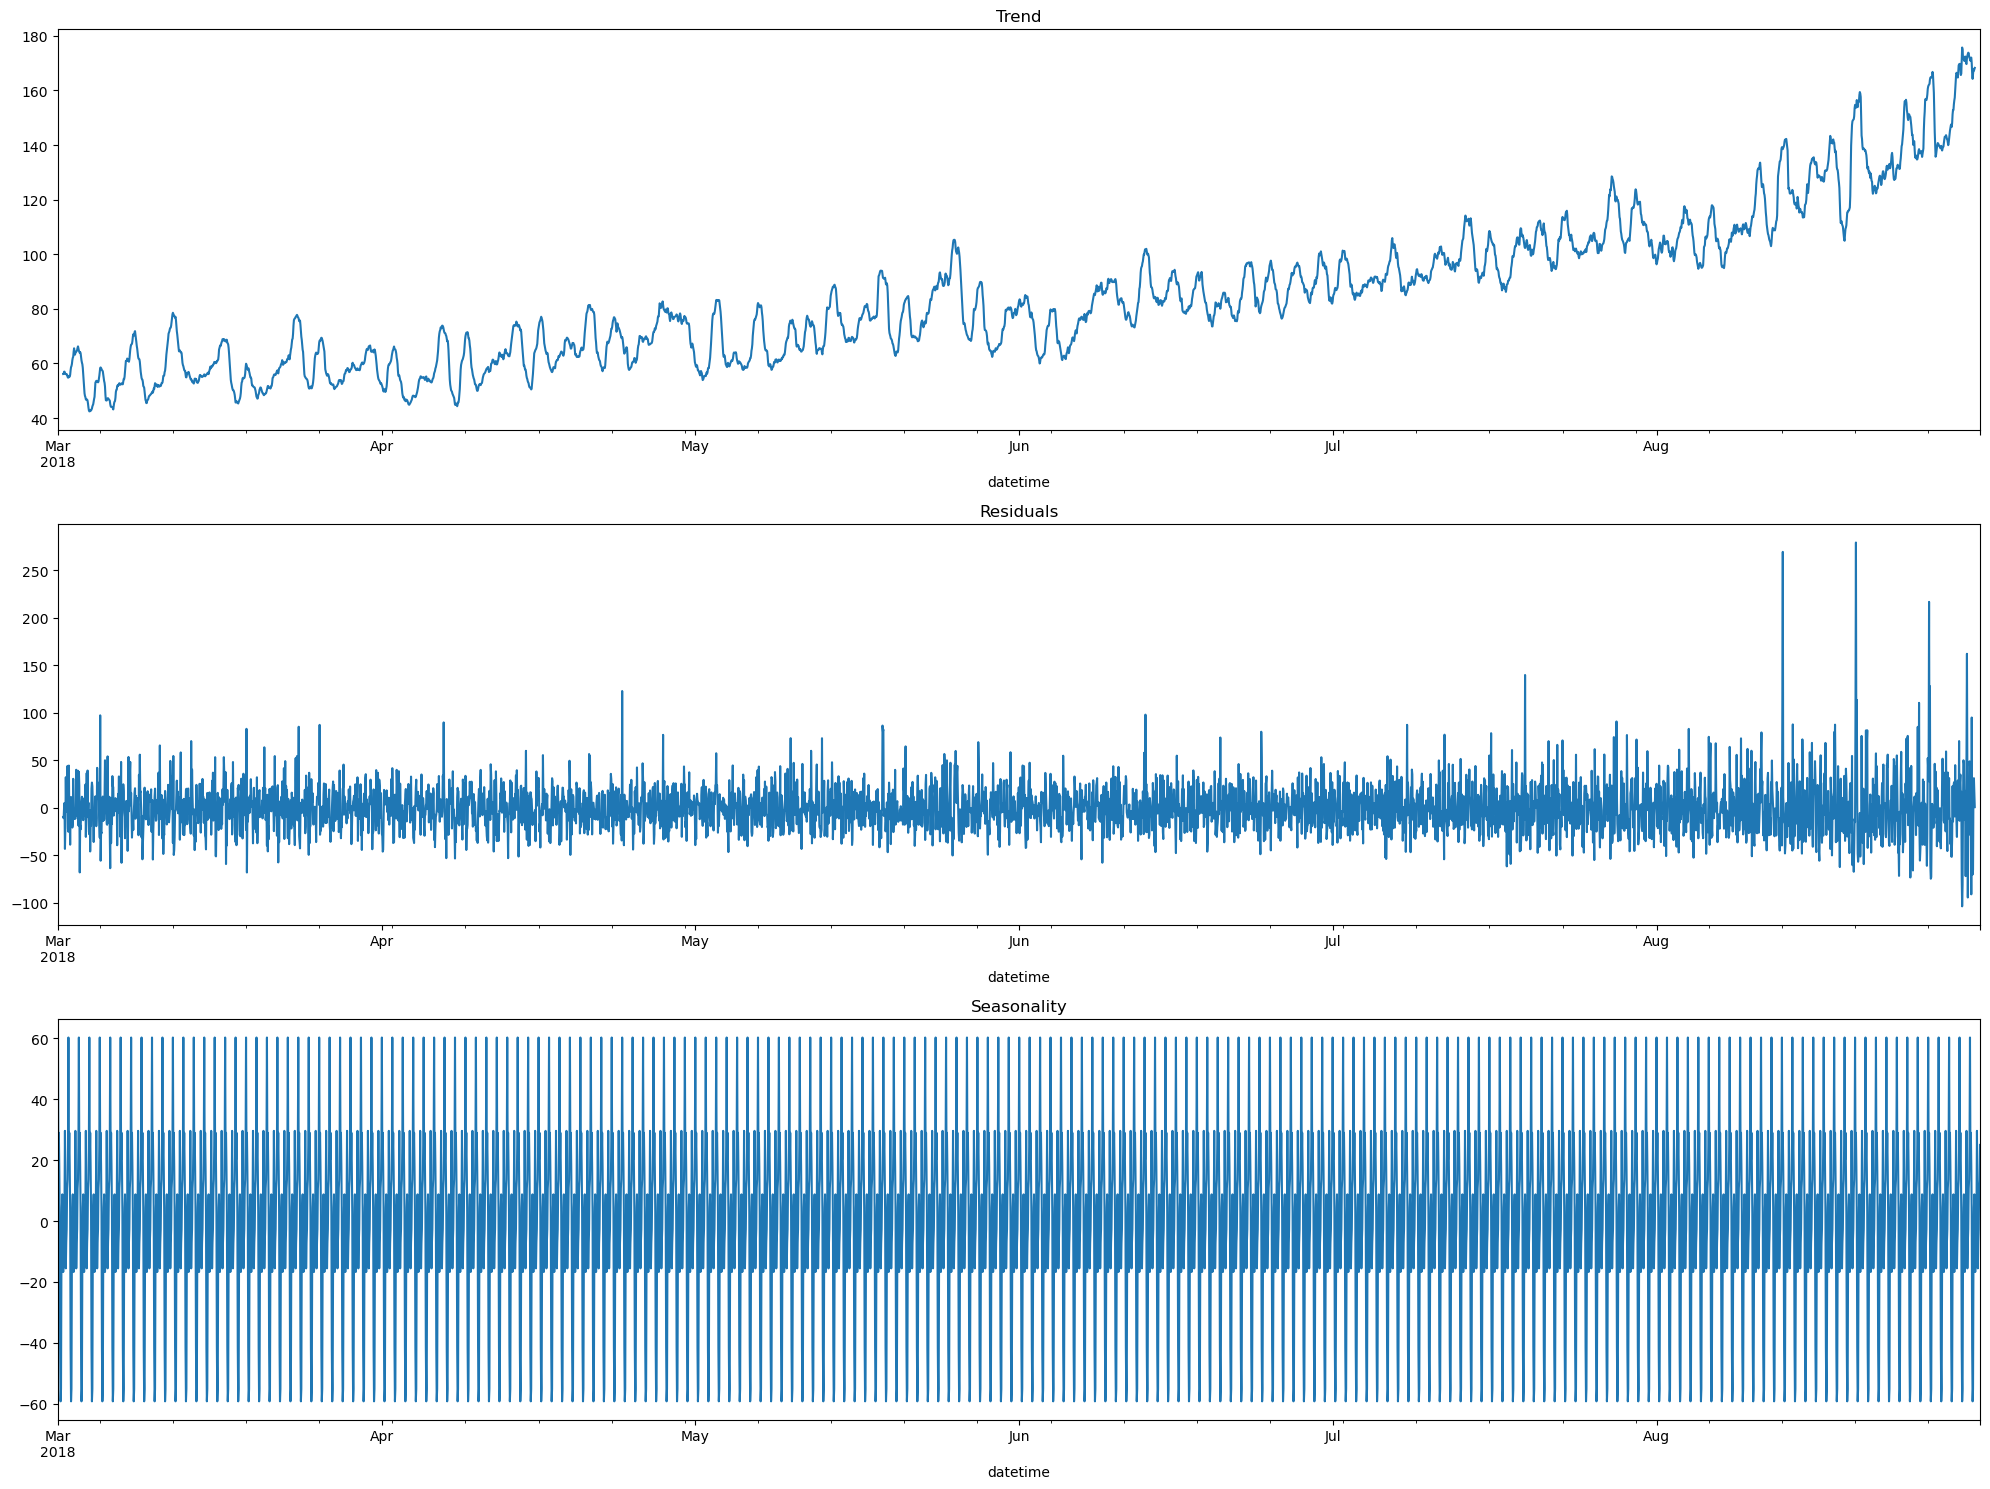

In [16]:
#распределение общего количества данных
decomposed_data = seasonal_decompose(data)
plt.figure(figsize=figsize)
plt.subplot(311)
decomposed_data.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_data.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.subplot(313)
decomposed_data.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

При изучении тренда и сезонности общих данных о количестве заказов такси можно увидеть рост количества заказов за последний период данных(август 2018).

In [17]:
#распределение по времени года
spring = data.copy()
spring = spring['2018-03-01 00:00:00 	':'2018-05-31 00:00:00 	']
spring = spring.resample('1W').sum()
summer = data.copy()
summer = summer['2018-06-01 00:00:00 	':'2018-08-31 00:00:00 	']
summer = summer.resample('1W').sum()

Text(0.5, 1.0, 'Распределение количества заказов весной  с семплированием в одну  неделю')

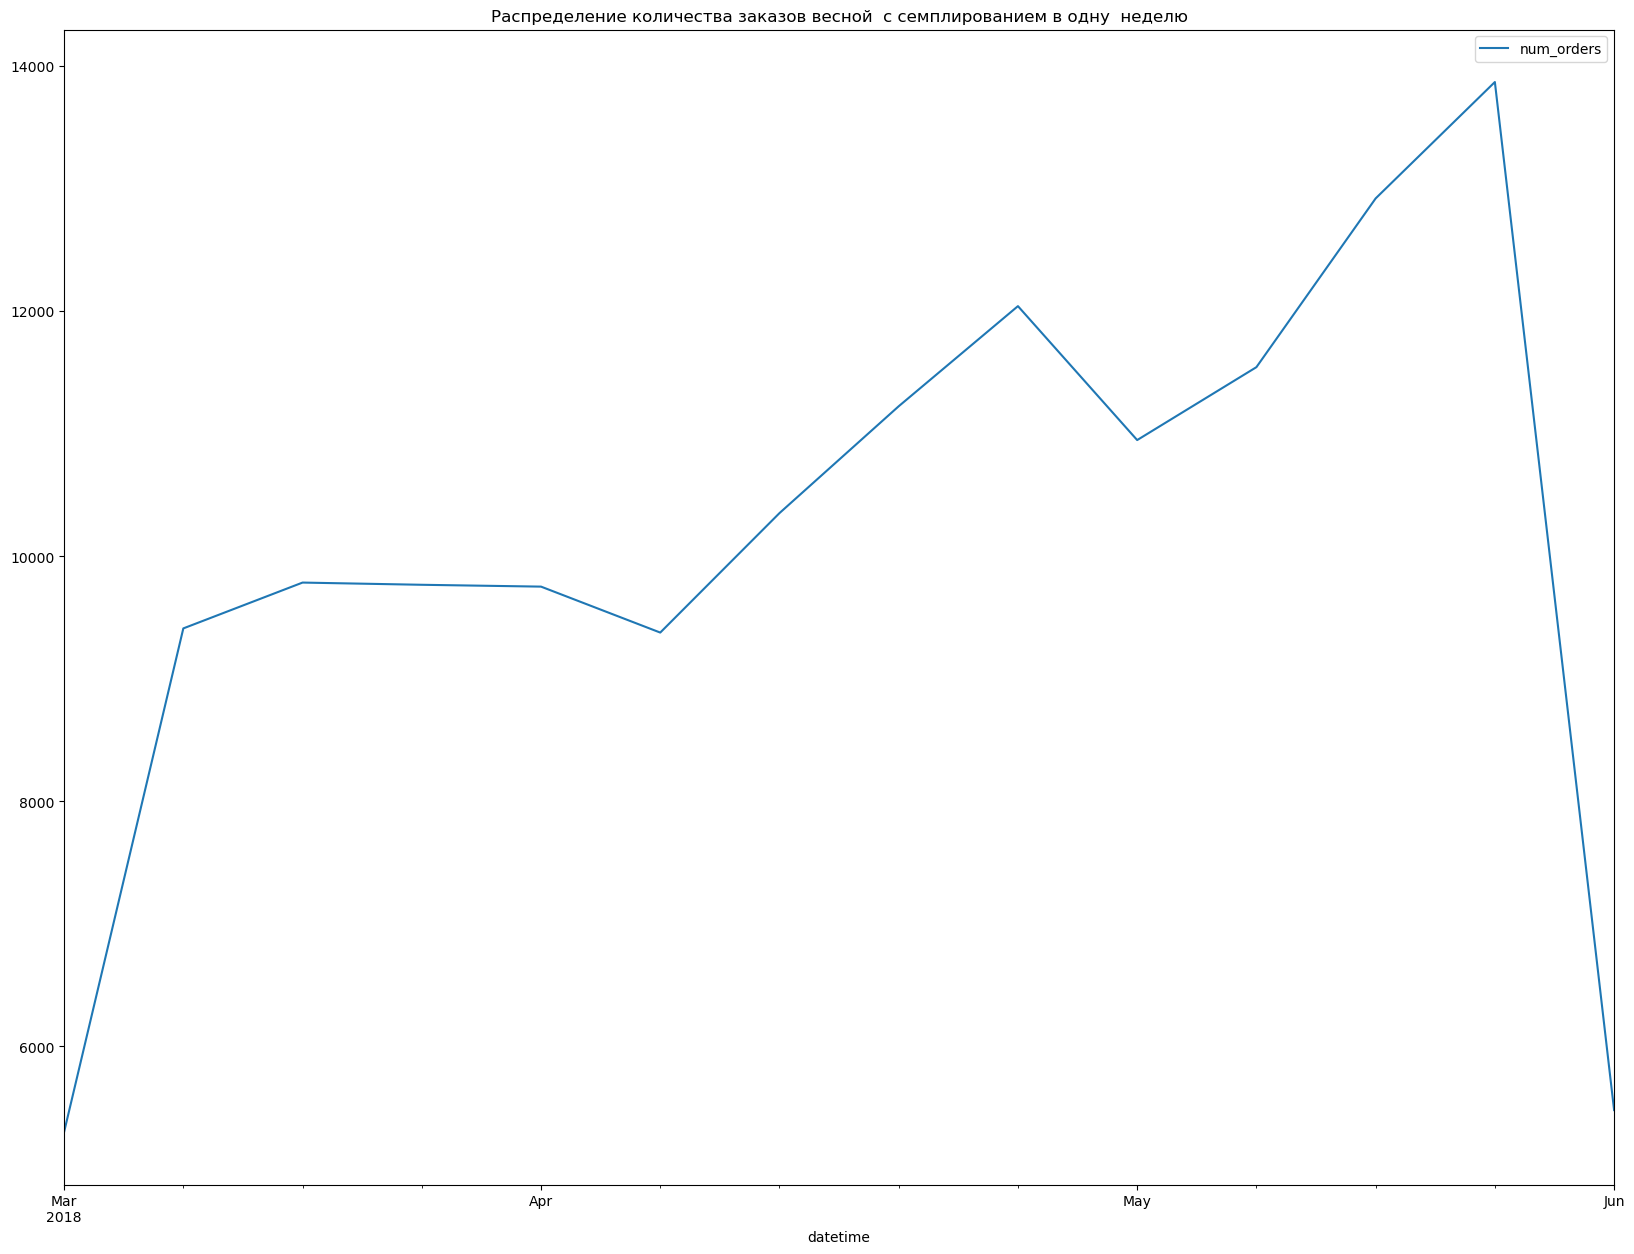

In [18]:
spring.plot(figsize=figsize)
plt.title('Распределение количества заказов весной  с семплированием в одну  неделю')


Text(0.5, 1.0, 'Распределение количества заказов летом  с семплированием в одну неделю')

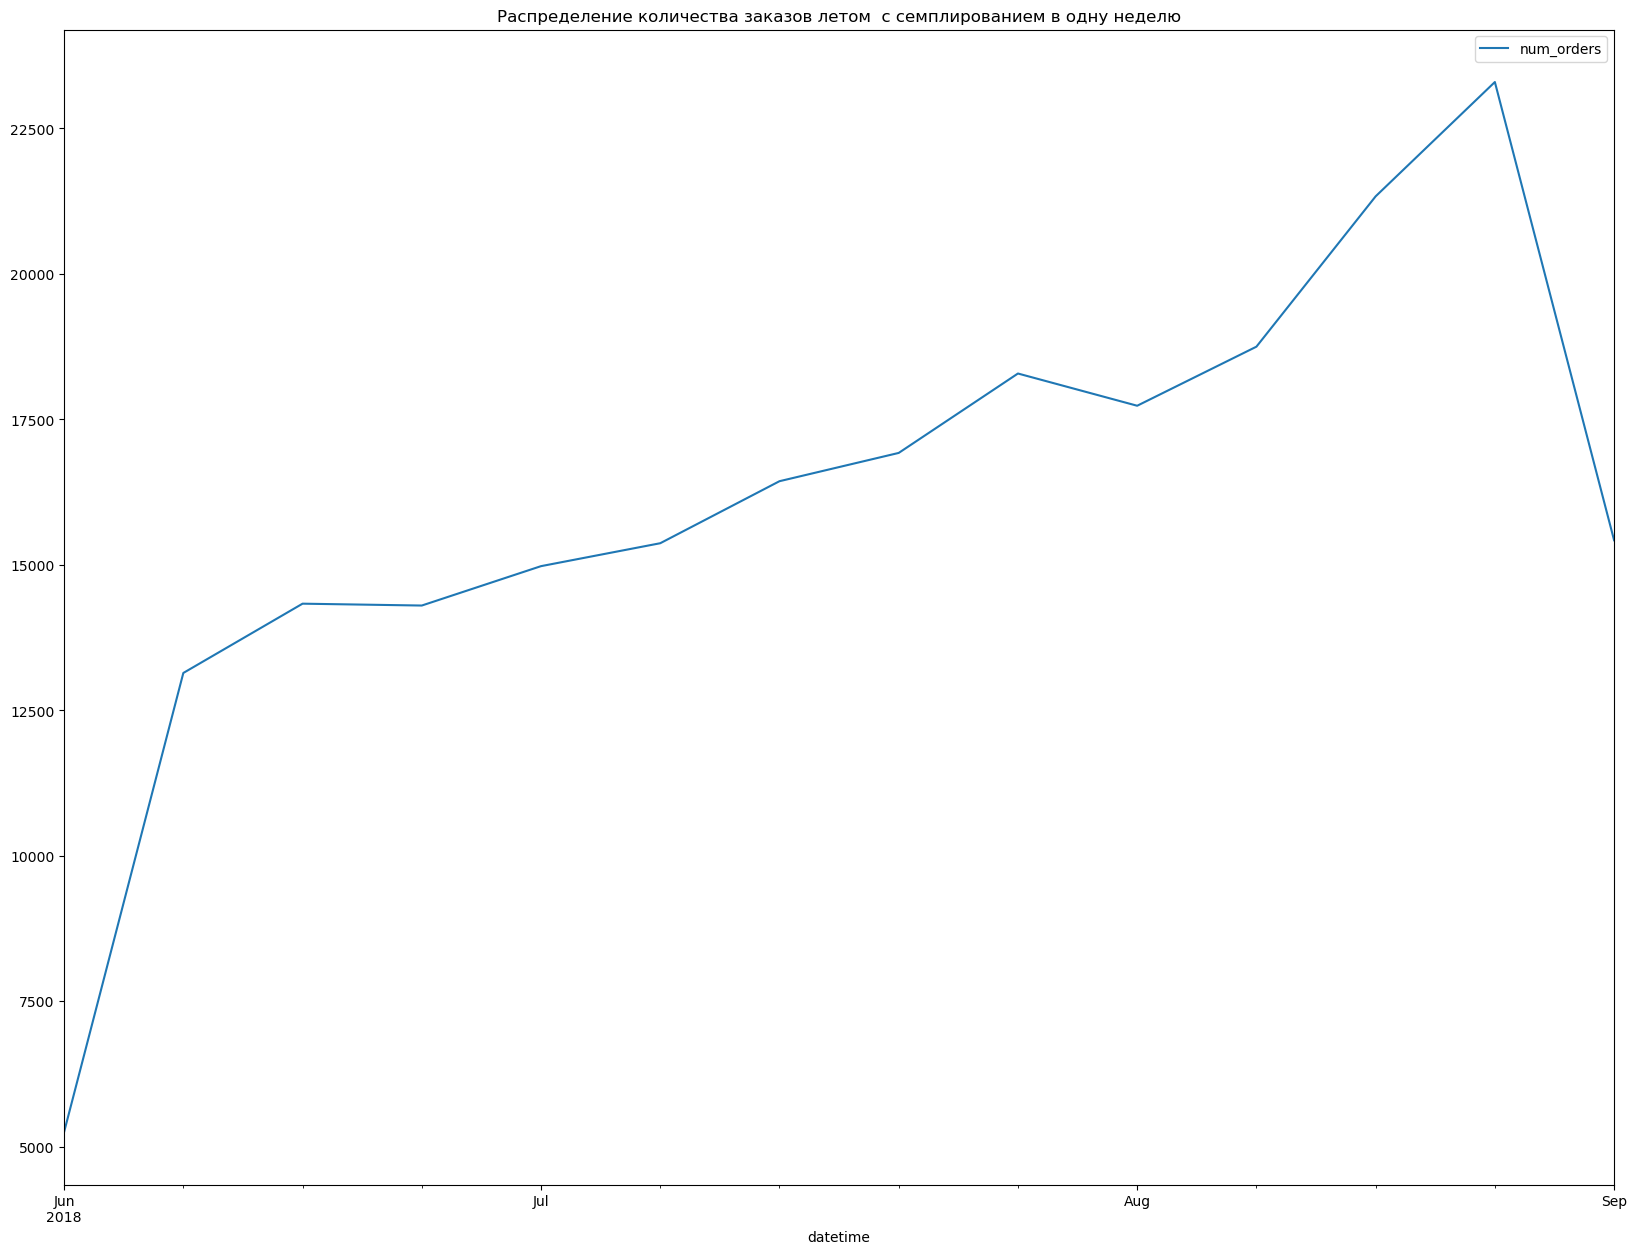

In [19]:
summer.plot(figsize=figsize)
plt.title('Распределение количества заказов летом  с семплированием в одну неделю')

При изучении двух сезонов общего суммарного распределения количества заказов с семплированием в 1 неделю, наибольшее количество заказов встречается в мае и августе. Март, июнь наименьшее распределение суммарного количества заказов среди сезонов

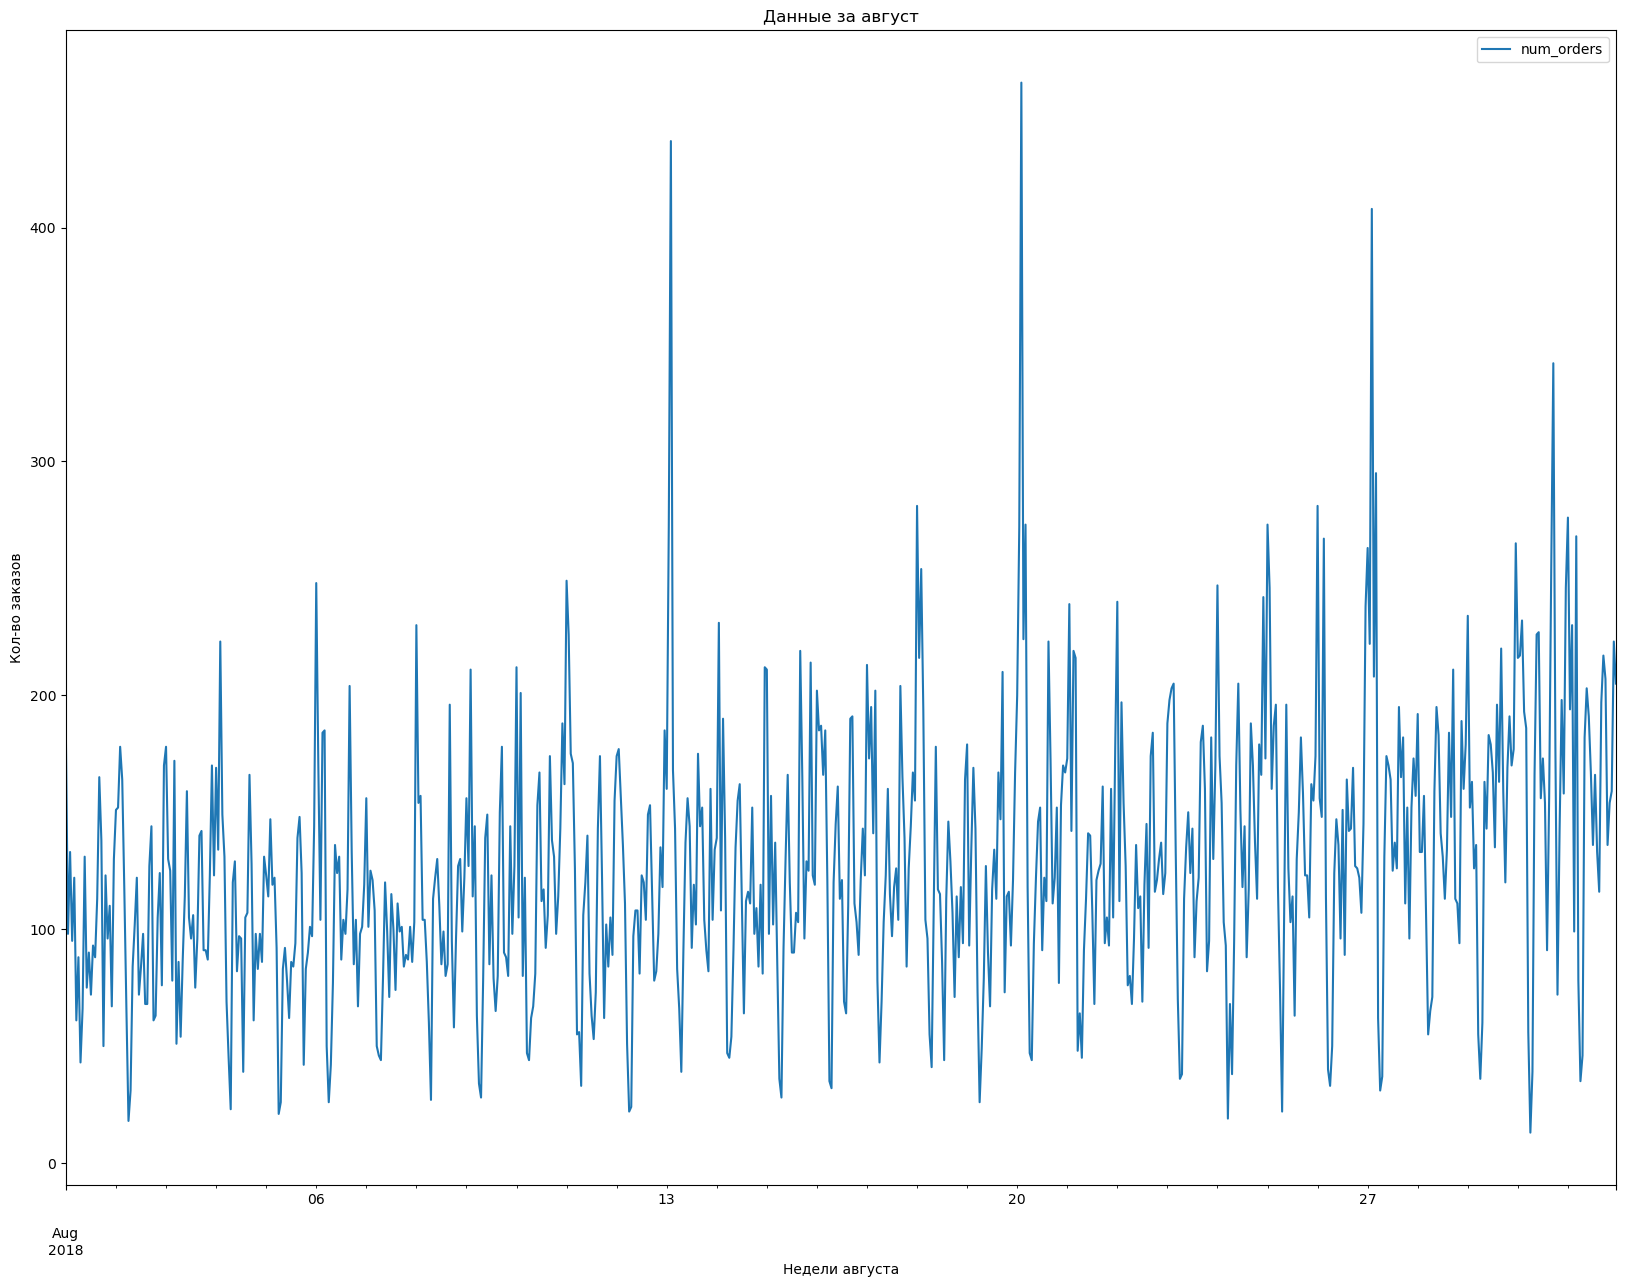

In [20]:
#вывожу график за август:
taxi_aug = data['2018-08':]
taxi_aug.plot(figsize=figsize)
plt.title('Данные за август')
plt.xlabel('Недели августа')
plt.ylabel('Кол-во заказов')
plt.show()

При рассмотрения последнего месяца заказов 13, 20, 27 августа был рост заказов.

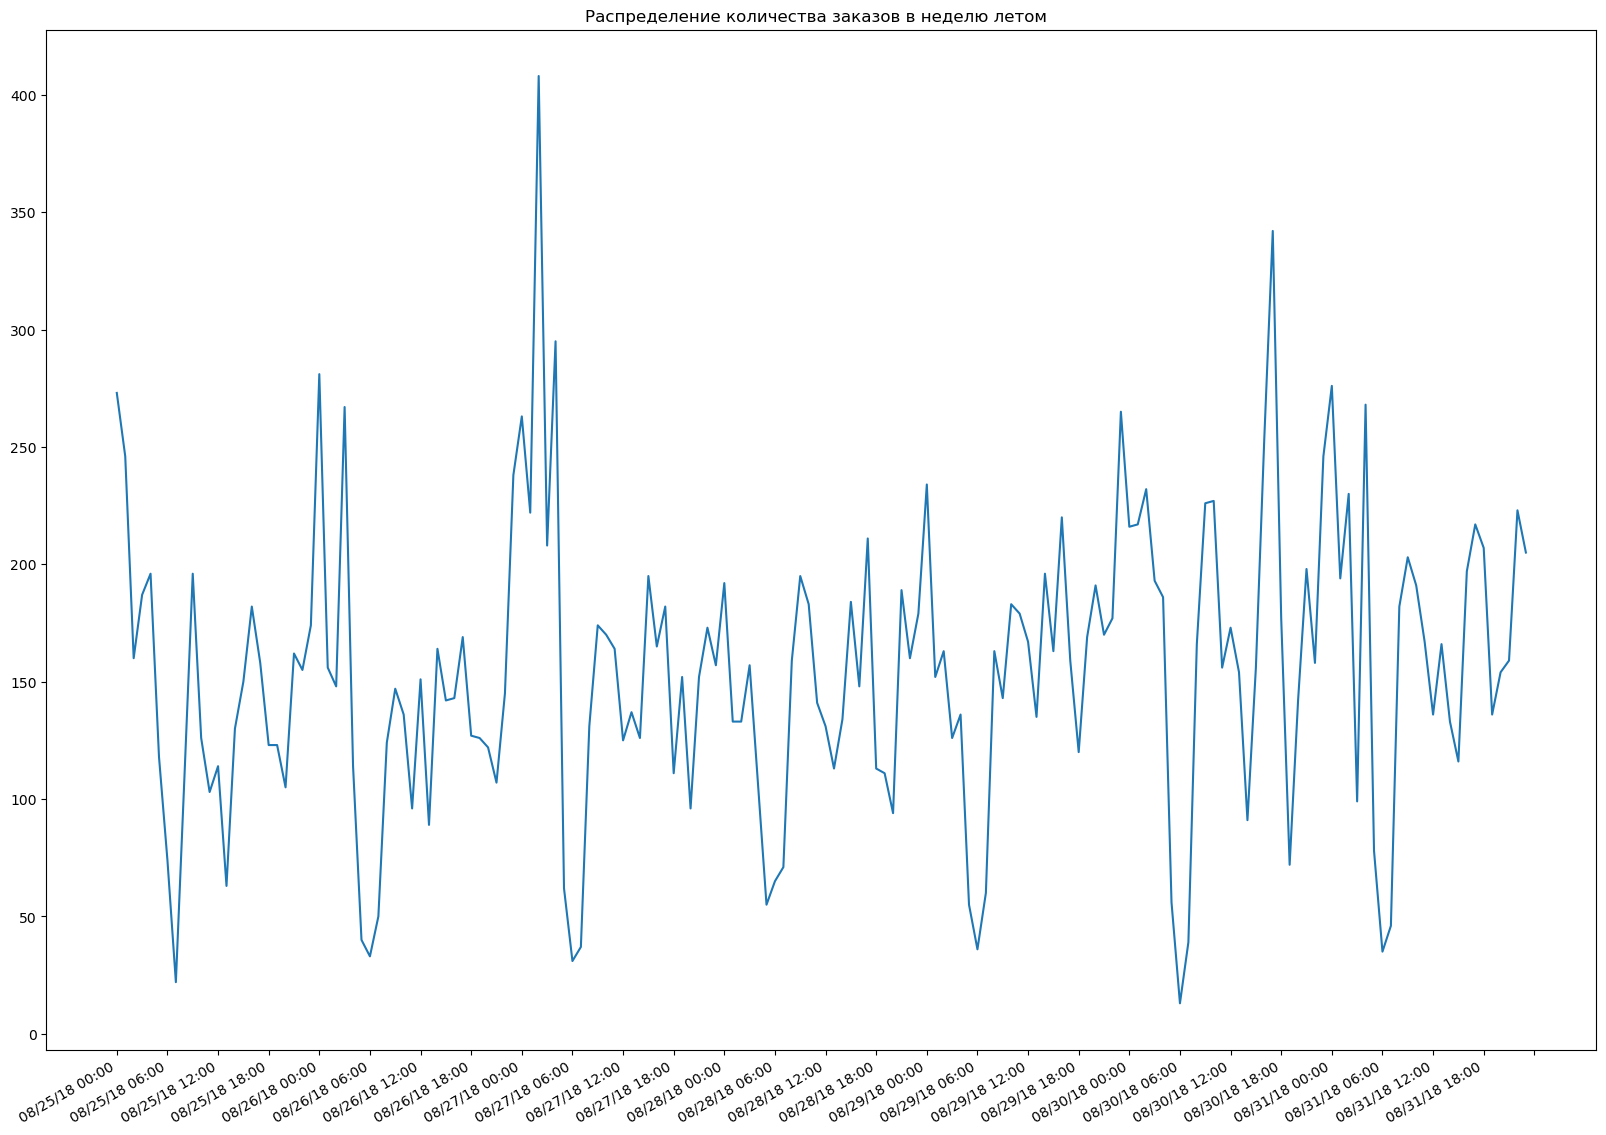

In [21]:
#распределение по неделе
Weeksummer = data.copy()
Weeksummer = Weeksummer['2018-08-25':'2018-08-31']
fig, ax = plt.subplots(figsize=figsize)
ax.plot(Weeksummer.index.strftime('%x %H:00'), Weeksummer)
plt.title('Распределение количества заказов в неделю летом  ')
ax.set_xticks(np.arange(0, len(Weeksummer)+1, 6))
fig.autofmt_xdate();

При рассмотрениии графика о распределении заказов такси с 25.08.2018 по 31.08.2018 г. можно наблюдать рост количества заказов в ночь с 26 по 27 августа и днем 30 августа, а также пик снижения количества заказов 06:00 30 августа 2018 г.

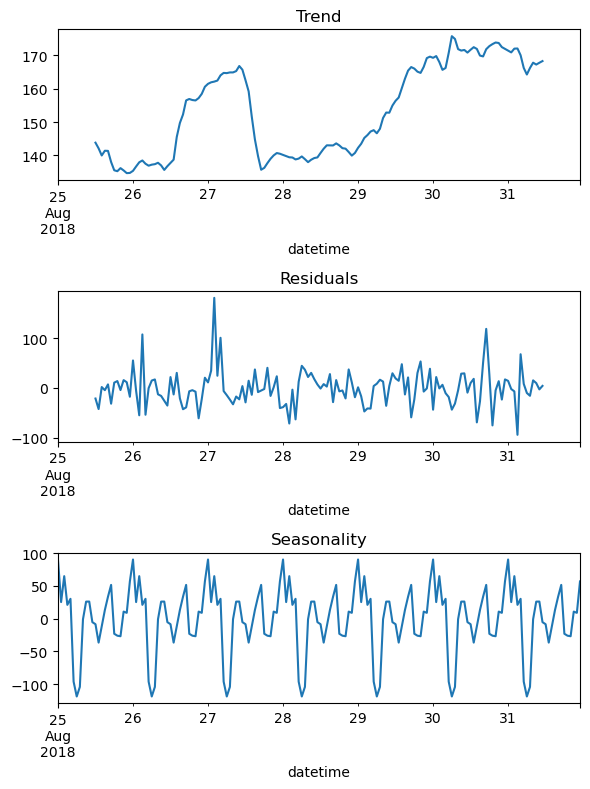

In [22]:
data_week = data.copy()
decomposed = seasonal_decompose(data['2018-08-25':'2018-08-31'])# < напишите код здесь >

plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.resid.plot(ax=plt.gca())# < напишите код здесь >
plt.title('Residuals')
plt.subplot(313)
decomposed.seasonal.plot(ax=plt.gca())# < напишите код здесь >
plt.title('Seasonality')
plt.tight_layout()

Исходя из графика по суммарному распределению количества заказов(семплирование по дням) наибольшее количество заказов в пятницу и субботу. Наименьшее количество заказов вторник, среда.


<AxesSubplot:xlabel='datetime'>

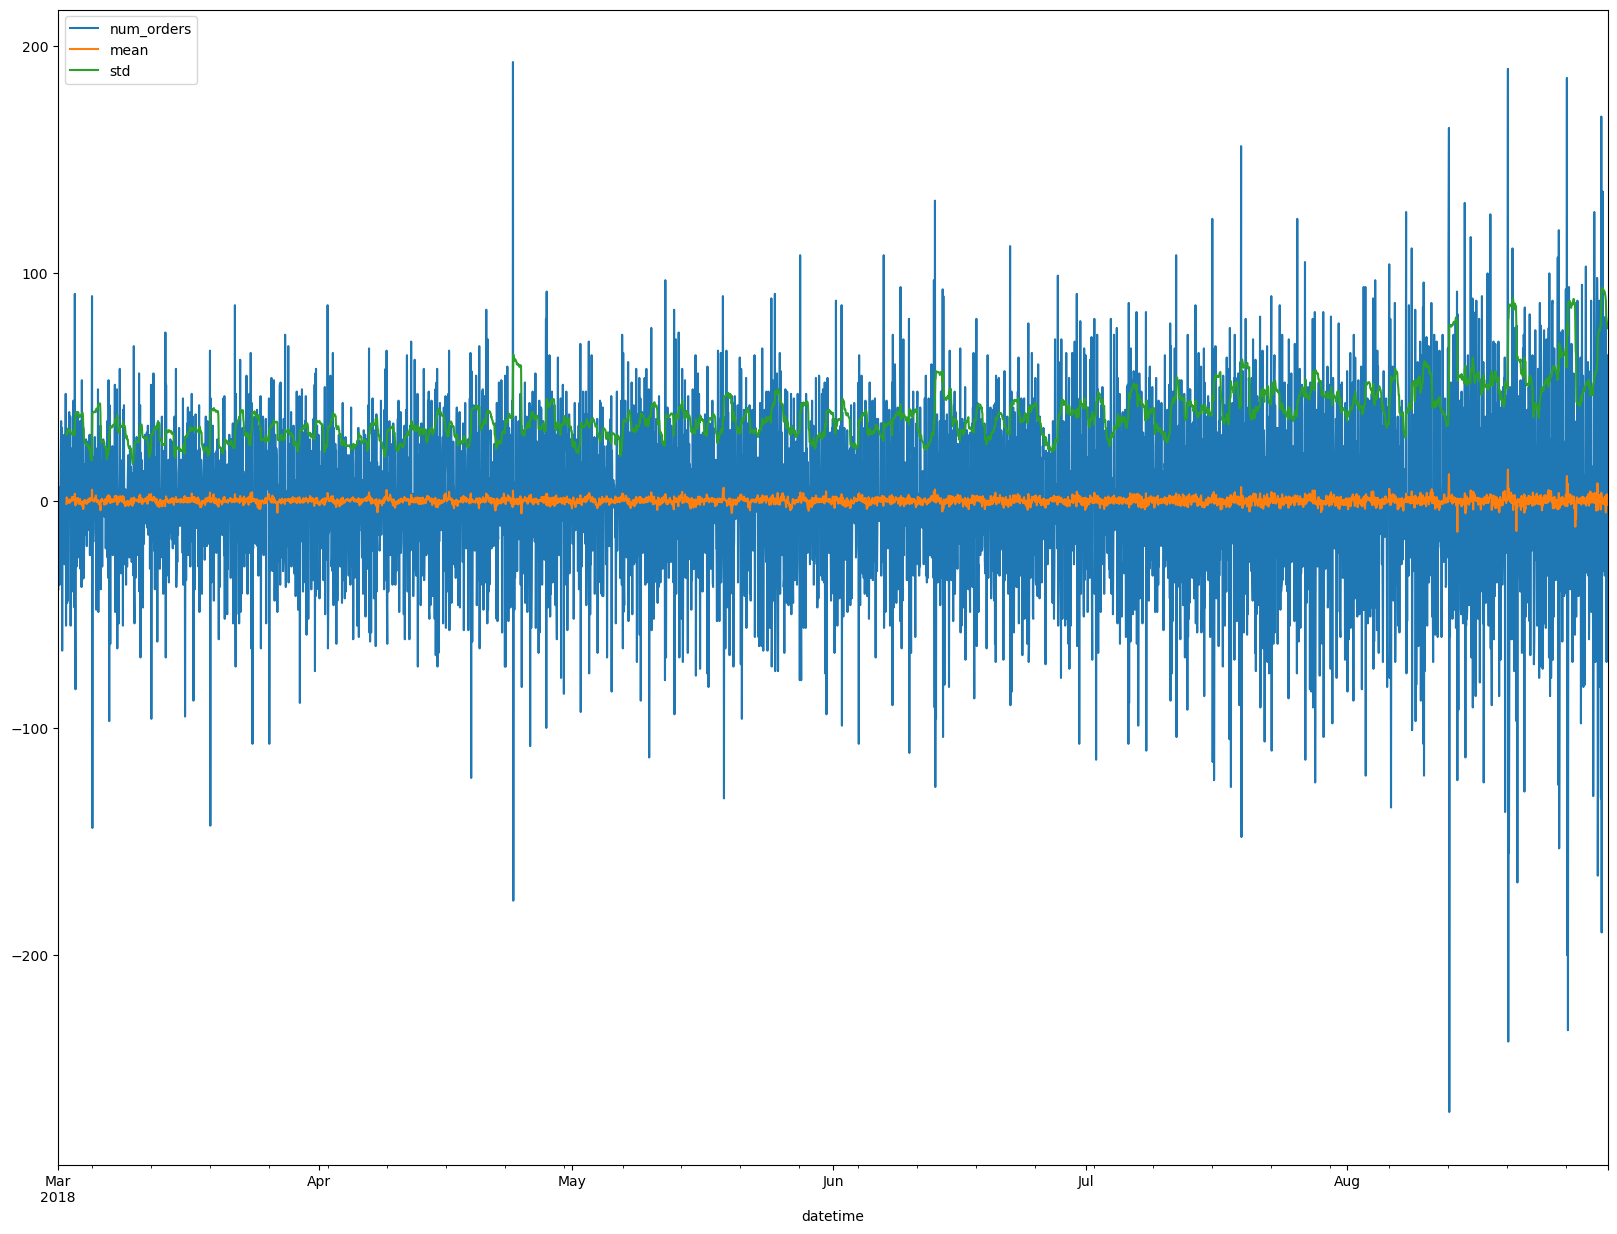

In [23]:
data_shift = data - data.shift()
data_shift['mean'] = data_shift['num_orders'].rolling(24).mean()
data_shift['std'] = data_shift['num_orders'].rolling(24).std()
data_shift.plot(figsize=figsize)

Исходя из данных на графике, данные представлены с марта по август 2018 года. Наибольшая активность в отдельно взятом дне за 23 часа 50 минут встречается в утренние(с 8 до 11 часов) и вечерние часы(с 19 до 21). При этом резкое снижение заказов наблюдается в ранние утренние часы(с 5 до 7 утра) и в дневное время(с 12 до 13). Произведено семплирование в один час.

За неделю наибольшая активность в понедельник в пятницу и субботу, наименьшя активность в воскресенье. Вторник, среда и четверг имеют одинаковую активность.

Датасет представлен двумя столбцами. Было произведено семплирование по 1 часу, согласно описанию к проекту. Максимальное количество заказов было 13 и 27 августа 2018 года. Пропусков в датасете нет. Данные расположены в хронологическом порядке.

Произведен исследовательский анализ данных согласно, которому:

    Я рассмотрела и сравнила количество заказов 05.03.2018 и 20.08.2018. Оба дня являются понедельниками. Имелись общие закономерности в данных Наибольшее количество заказов поступает в периоды времени с 00:00 до 04:00 утра. С 04:00 до 09:00 утра самое низкое количество заказов такси. с 09:00 до 12:00 опять наблюдается рост количества заказов такси. С 15:00 до 21:00 опять начинается рост количества заказов. С 12 до 14 наблюдается снижение заказов.

    При изучении тренда и сезонности общих данных о количестве заказов такси можно увидеть рост количества заказов за последний период данных(август 2018)

    При изучении двух сезонов общего суммарного распределения количества заказов с семплированием в 1 неделю, наибольшее количество заказов встречается в мае и августе.

    При рассмотрения последнего месяца заказов 13, 20, 27 августа был рост заказов.

    При рассмотрениии графика о распределении заказов такси с 25.08.2018 по 31.08.2018 г. можно наблюдать рост количества заказов в ночь с 26 по 27 августа и днем 30 августа, а также пик снижения количества заказов 06:00 30 августа 2018 г. Необходима проверка стационарности временного ряда



# 1.2 Тест Дики-Фуллера

Это методика, которая используется в прикладной статистике и эконометрике для анализа временных рядов для проверки на стационарность.

In [24]:

#проверка временного ряда тестом Дики-Фуллера на стационарность
from statsmodels.tsa.stattools import adfuller
TDF = data['num_orders']
TDF_test = adfuller(TDF, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if TDF_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')

Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


 Исходя из того, что для моделирования временных рядов ряд должен быть стационарен. Когда временной ряд является стационарным, его легче моделировать.

Методы статистического моделирования предполагают или требуют, чтобы временные ряды были стационарными, чтобы быть эффективными.

Для этого я использовала метод Дики-Фуллера. При применении данного метода выяснилось, что временной ряд данных стационарен.


# 2. Разделение на выборки

Перед разделением на выборки я применила функцию для создания новых столбцов 'year','month','day','weekday' c max_lag(опозданием 24 часа так как произведено семплирование по часу).

In [25]:
data_1 = data.copy()
def make_features(data_1, max_lag, rolling_mean_size):
    data_1['year'] = data_1.index.year
    data_1['month'] = data_1.index.month
    data_1['day'] = data_1.index.day
    data_1['weekday'] = data_1.index.weekday
    
    for lag in range(1, max_lag + 1):
        data_1['lag_{}'.format(lag)] = data_1['num_orders'].shift(lag)

    data_1['rolling_mean'] = data_1['num_orders'].shift().rolling(rolling_mean_size).mean()

In [26]:
make_features(data_1, 24, 100)

In [27]:
data_1 = data_1.dropna()

In [28]:
#разделение на выборки
train,test = train_test_split(data_1,shuffle = False, random_state = 12345, test_size = 0.1)

In [29]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Для временного ряда необходимо использовать TimeSeriesSplit с определением сплита на основе размере выборки таргета.

In [30]:
test_size = 0.1

# This conversion is found in the source of TimeSeriesSplit
# число сплитов на основе размеров выборок
n_splits_calc = (len(target_train) // len(target_test)) - 1
# сплиттер таймсерий для оптимизатора
splitter = TimeSeriesSplit(n_splits=n_splits_calc)

Перед разделением на выборки я применила функцию для создания новых столбцов 'year','month','day','weekday' c max_lag(опозданием 24 часа так как произведено семплирование по часу). Также была произведено разделение на выборки на тренировочную и тестовую. Размер тестовой выборки 10%. Для временного ряда с моделированием необходимо использовать TimeSeriesSplit с определением сплита на основе размере выборки таргета.


# 2.1 Линейная регрессия

In [31]:
%%time


model_lin = LinearRegression()
#Обучаю модель
model_lin.fit(features_train, target_train)
#Определяю RMSE модели с помощью кросс-валидации
regression_cv_score = cross_val_score(model_lin,features_train,target_train,scoring='neg_root_mean_squared_error', cv=splitter)
print('RMSE', abs (regression_cv_score.mean()))

RMSE 28.071653977161855
Wall time: 93.8 ms


In [32]:
%%time
lin_pred = model_lin.predict(features_train)

Wall time: 15.6 ms


При использовании модели 'Логистическая регрессия' с кросс-валидацией время обучения 0.15 с, время предсказания 0.007 сек. RMSE равен 28.07.

# 2.2 LGBM бустинг

In [33]:
def lgb_regr(features, target):
    model = LGBMRegressor()
    params = {
        'boosting_type' : ['gbdt'],
        'n_estimators' : [50, 100,],
        'max_depth' : [5, 7, 10,],
        'verbose' : [-1],
        'random_state' : [1,2,3,4,5],
        'force_col_wise': [True],
        'num_leaves' : [127]}
    grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=splitter, n_jobs=-1, scoring='neg_root_mean_squared_error')
    grid_cv.fit(features_train, target_train)
    print('Лучшие гиперпараметры: ', grid_cv.best_params_)
    print('RMSE:: {:.2f} '.format(grid_cv.best_score_* -1))
    return grid_cv.best_params_

In [34]:
%%time
lgb_params = lgb_regr(features_train, target_train)

Лучшие гиперпараметры:  {'boosting_type': 'gbdt', 'force_col_wise': True, 'max_depth': 7, 'n_estimators': 50, 'num_leaves': 127, 'random_state': 1, 'verbose': -1}
RMSE:: 25.37 
Wall time: 30.9 s


In [35]:
%%time
model_lgb = LGBMRegressor(**lgb_params)
model_lgb.fit(features_train, target_train)
lgb_pred = model_lgb.predict(features_train)

Wall time: 348 ms


При использовании модели бустинга LGBM с гридсерчем при лучших гиперпараметрах {'boosting_type': 'gbdt', 'force_col_wise': True, 'max_depth': 7, 'n_estimators': 50, 'num_leaves': 127, 'random_state': 1, 'verbose': -1: RMSE равен 25.37 со скоростью обучения 30.9 сек., временем предсказания 0.35 сек.



# 2.3 Catboost

In [36]:
def catboost_regr(features, target):
    model = CatBoostRegressor()
    params = {
            'n_estimators' : [50, 100],
            'verbose' : [0],
            'random_state' : [1, 2, 3, 4, 5],
            'max_depth' : [5, 7, 10]
    }
    grid_cv = GridSearchCV(estimator=model, 
    param_grid=params, cv=3, n_jobs=-1, scoring='neg_root_mean_squared_error')
    grid_cv.fit(features_train, target_train, verbose=10)
    print('Лучшие гиперпараметры: ', grid_cv.best_params_)
    print('RMSE:: {:.2f} '.format(grid_cv.best_score_* -1))
    return grid_cv.best_params_

In [37]:
%%time
catb_params = catboost_regr(features_train, target_train)

Learning rate set to 0.329827
0:	learn: 33.9196281	total: 150ms	remaining: 14.8s
10:	learn: 24.3063669	total: 230ms	remaining: 1.86s
20:	learn: 22.7907101	total: 310ms	remaining: 1.17s
30:	learn: 21.4453555	total: 377ms	remaining: 840ms
40:	learn: 20.5108192	total: 451ms	remaining: 650ms
50:	learn: 19.6401994	total: 530ms	remaining: 509ms
60:	learn: 18.8350058	total: 599ms	remaining: 383ms
70:	learn: 18.1156688	total: 680ms	remaining: 278ms
80:	learn: 17.5043626	total: 754ms	remaining: 177ms
90:	learn: 16.8574924	total: 825ms	remaining: 81.6ms
99:	learn: 16.2980765	total: 894ms	remaining: 0us
Лучшие гиперпараметры:  {'max_depth': 5, 'n_estimators': 100, 'random_state': 1, 'verbose': 0}
RMSE:: 25.64 
Wall time: 4min 48s


In [38]:
%%time
catb_model = CatBoostRegressor(**catb_params)
catb_model.fit(features_train, target_train)
catb_pred = catb_model.predict(features_train)


Wall time: 1.03 s


При использовании модели бустинга Catboost с гридсерчем при лучших гиперпараметрах 'max_depth': 7, 'n_estimators': 100, 'random_state': 1, 'verbose': 0 RMSE равен 25.64 со скоростью обучения 288 сек., временем предсказания 1.03 сек.


# 2.4 XGB_Regressor

In [39]:
def xgb_regr(features, target):
    model = XGBRegressor()
    params = {
        'max_depth': [3, 5, 7], 
         'eta': [0.5], 
         'min_child_weight':[4],
         'sampling_method':['gradient_based'], 
         'verbosity':[1],  
         'seed':[1, 2, 3, 4, 5]}
    grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=2, n_jobs=-1, scoring='neg_root_mean_squared_error')
    grid_cv.fit(features, target, eval_metric='rmse', verbose = 10, eval_set = [(features_train, target_train)])
    print('Best hyperparams: ', grid_cv.best_params_)
    print('RMSE:: {:.2f} '.format(grid_cv.best_score_* -1))
    return grid_cv.best_params_

In [40]:
%%time
xgb_params = xgb_regr(features_train, target_train)

[0]	validation_0-rmse:49.33499
[10]	validation_0-rmse:18.33433


C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:15.53433
[30]	validation_0-rmse:13.91145
[40]	validation_0-rmse:11.86211
[50]	validation_0-rmse:10.76166
[60]	validation_0-rmse:9.44739
[70]	validation_0-rmse:8.64283
[80]	validation_0-rmse:7.64152
[90]	validation_0-rmse:6.75827
[99]	validation_0-rmse:6.22694
Best hyperparams:  {'eta': 0.5, 'max_depth': 5, 'min_child_weight': 4, 'sampling_method': 'gradient_based', 'seed': 1, 'verbosity': 1}
RMSE:: 31.30 
Wall time: 15.6 s


In [41]:
%%time
xgb_model = XGBRegressor(**xgb_params)
xgb_model.fit(features_train, target_train)
xgb_pred = xgb_model.predict(features_train)


Wall time: 878 ms


При использовании модели бустинга XGB с гридсерчем при лучших гиперпараметрах 'eta': 0.5, 'max_depth': 3, 'min_child_weight': 4, 'sampling_method': 'gradient_based', 'seed': 1, 'verbosity': 1 'verbosity': 1 RMSE равен 31.30 со скоростью обучения 15.6 сек., временем предсказания 0.88 сек.


# 3. Анализ моделей

In [46]:
index = ['Логистическая регрессия',
         'LightGBM ',
         'CatBoost',
         'XGB']
MODEL = {'RMSE на тренировочной выборке':[28.07,
                25.37,
                25.64,
                31.30],
        'Время обучения модели в сек.':[0.15,
                                 30.9,
                                 288,
                                 15.6],
        
        'Время предсказания модели':[0.007,
                                     0.35,
                                     0.65,
                                     1.03]
         }
MODEL = pd.DataFrame(data=MODEL, index=index)    

In [47]:
MODEL
MODEL.style\
    .background_gradient(cmap='coolwarm')

,RMSE на тренировочной выборке,Время обучения модели в сек.,Время предсказания модели
Логистическая регрессия,28.070000,0.150000,0.007000
LightGBM,25.370000,30.900000,0.350000
CatBoost,25.640000,288.000000,0.650000
XGB,31.300000,15.600000,1.030000


Исходя из анализа моделей LGBM показал наилучшие результаты RMSE на тренировочной выборке 25.23. 

# 4.Тестирование модели

In [42]:
%%time

model_lgb = LGBMRegressor(**lgb_params)
model_lgb.fit(features_train, target_train)
lgb_pred = model_lgb.predict(features_test)
print('RMSE:: {:.2f} '.format(mean_squared_error(target_test, lgb_pred) ** .5))

RMSE:: 42.37 
Wall time: 267 ms


In [50]:
features_test.index.min()

Timestamp('2018-08-14 00:00:00', freq='H')

In [51]:
features_train.index.max()

Timestamp('2018-08-13 23:00:00', freq='H')

Text(0.5, 1.0, 'Тестирование модели CatBoost')

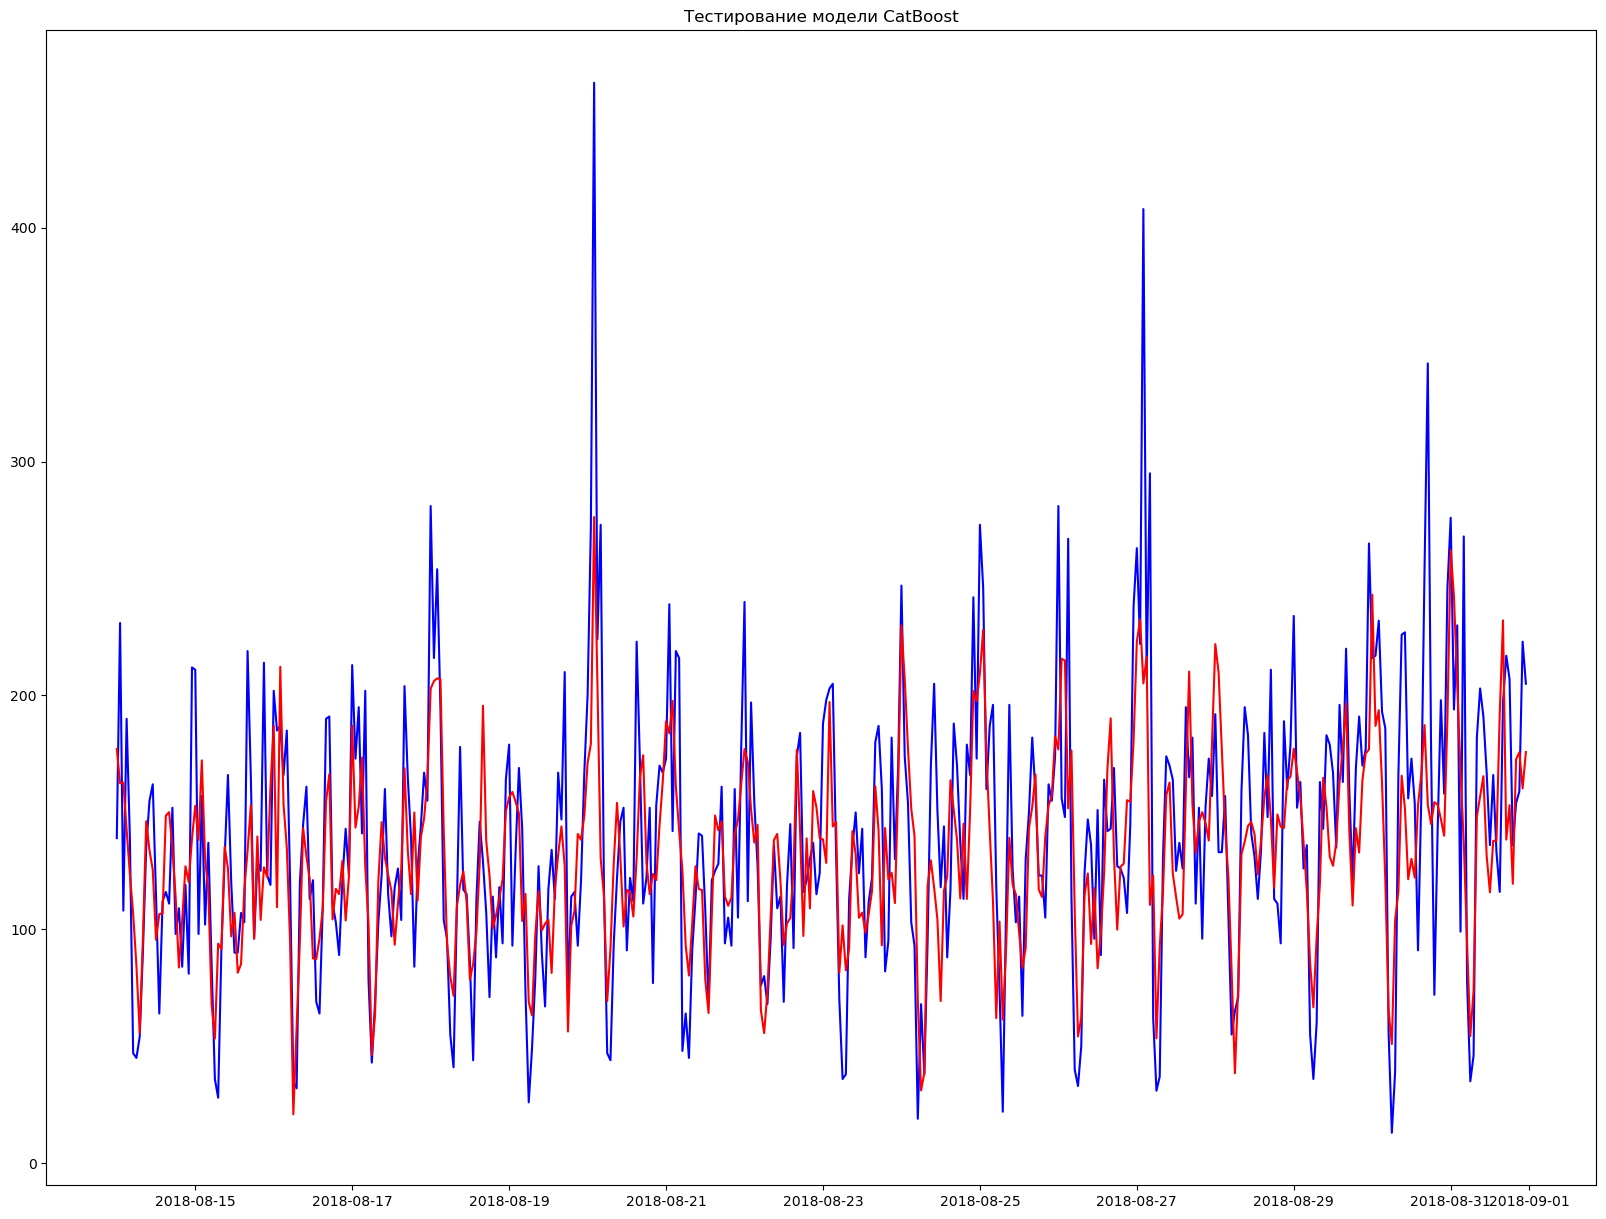

In [52]:
plt.figure(figsize=figsize)
plt.plot(target_test.index, 
         target_test, 
         'b-', 
         target_test.index, 
         catb_pred,
         'r-')
plt.title('Тестирование модели CatBoost')

В моделировании были использованы Линейная регрессия, LGBM, Catboost, XGB. Наилучший результат RMSE показала Catboost на тренировочной выборке 25,23 с временм обучения 351, временем предсказания 0.65. Для тестирования была применен LGBM с результатом 42.37, что оказалось немного хуже,чем на тренировочной выборке с временем предсказания 0.27 сек.

# Вывод общий

 Произведено семплирование в один час.

Также был осуществлен исследовательский анализ данных согласно, которому:

Я рассмотрела и сравнила количество заказов 05.03.2018 и 20.08.2018. Оба дня являются понедельниками. Имелись общие закономерности в данных Наибольшее количество заказов поступает в периоды времени с 00:00 до 04:00 утра. С 04:00 до 09:00 утра самое низкое количество заказов такси. с 09:00 до 12:00 опять наблюдается рост количества заказов такси. С 15:00 до 21:00 опять начинается рост количества заказов. С 12 до 14 наблюдается снижение заказов.

При изучении тренда и сезонности общих данных о количестве заказов такси можно увидеть рост количества заказов за последний период данных(август 2018)

При изучении двух сезонов общего суммарного распределения количества заказов с семплированием в 1 неделю, наибольшее количество заказов встречается в мае и августе.

При рассмотрения последнего месяца заказов 13, 20, 27 августа был рост заказов.

При рассмотрениии графика о распределении заказов такси с 25.08.2018 по 31.08.2018 г. можно наблюдать рост количества заказов в ночь с 26 по 27 августа и днем 30 августа, а также пик снижения количества заказов 06:00 30 августа 2018 г. Необходима проверка стационарности временного ряда

Для проверки стационарного ряда был применен тест Дики-Фуллера.Перед разделением на выборки я применила функцию для создания новых столбцов 'year','month','day','weekday' c max_lag(опозданием 24 часа так как произведено семплирование по часу). Также была произведено разделение на выборки на тренировочную и тестовую. Размер тестовой выборки 10%. Для временного ряда с моделированием необходимо использовать TimeSeriesSplit с определением сплита на основе размере выборки таргета.

 В моделировании были использованы Линейная регрессия, LGBM, Catboost, XGB. Наилучший результат RMSE показала LGBM на тренировочной выборке 25.37 с временм обучения 30.9 , временем предсказания 0.35. 
Для тестирования была применен LGBM с результатом 42.37, что оказалось немного хуже,чем на тренировочной выборке  с временем предсказания 0.27 сек.